In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.externals.six.moves import zip
from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score  # 计算roc和auc
from sklearn.tree import DecisionTreeClassifier

In [3]:
## 设置属性防止中文乱码
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
## 创建模拟数据
X, y = make_gaussian_quantiles(n_samples=13000, n_features=10,
                               n_classes=3, random_state=1)

print('X:\n', X[:5])
print('y:\n', y[:5])

X:
 [[-0.53548325  1.35169708  0.34801047 -0.41580821 -0.9777562   0.56003499
  -1.41982597  0.44046489 -2.61270317 -0.57228031]
 [-0.28585287  0.19381619  1.31164797  1.50841947 -0.87964973  0.37354515
   0.47015359  0.33093069 -1.51132323 -0.47863497]
 [-0.51047669 -0.68765555 -0.94281252  0.53689282  0.88017647 -0.12963182
  -0.22207613  0.15793694 -0.54322461 -0.49440416]
 [-1.87283255  0.89947262 -0.60512396  1.23013416 -0.6911548   0.60789251
  -0.25620892  0.03325365  0.34851032 -0.44158787]
 [ 0.41371047  0.66370633 -1.12149776 -0.01096204 -0.44666372  0.82114773
  -0.87536342 -0.05586432  0.69335465  0.08446252]]
y:
 [2 1 0 0 0]


In [5]:
n_split = 3000

X_train, X_test = X[:n_split], X[n_split:]
y_train, y_test = y[:n_split], y[n_split:]

In [6]:
# 建立两个模型，algorithm算法不同，bdt_real选择的是samme.r
bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1,
    algorithm="SAMME")

bdt_real.fit(X_train, y_train)
bdt_discrete.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=600, random_state=None)

In [7]:
# 获得预测的准确率，accuracy_score，是单个分类器的准确率。
real_test_errors = []  # 第一个模型每一个分类器的误差率
discrete_test_errors = []  # 第二个模型每一个分类器的误差率

# staged_predict(X):返回每个基分类器的预测数据集X的结果/预测每一轮迭代后输入样本的预测值
for real_test_predict, discrete_train_predict in zip(
        bdt_real.staged_predict(X_test), bdt_discrete.staged_predict(X_test)):
    real_test_errors.append(
        1. - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(
        1. - accuracy_score(discrete_train_predict, y_test))

n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)
print("n_trees_real:\n", n_trees_real)
print("n_trees_discrete:\n", n_trees_discrete)

# 预测的误差率estimator_errors_ 数组，存放每个基本回归器的误差
discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]  # 获得权重

n_trees_real:
 600
n_trees_discrete:
 600


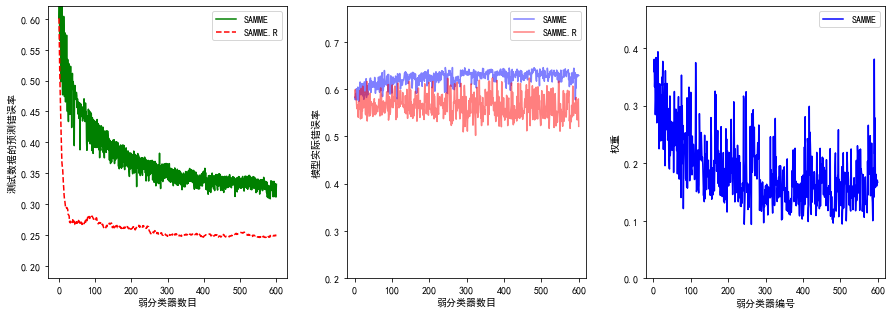

In [8]:
plt.figure(figsize=(15, 5), facecolor='w')

# 误差率绘制
plt.subplot(131)  # 一行三列 选择其中的第一列
plt.plot(range(1, n_trees_discrete + 1),  # x范围
         discrete_test_errors,            # y范围 为错误率每一轮迭代后的错误率
         c='g', label='SAMME')  # SAMME算法下的误差率
plt.plot(range(1, n_trees_real + 1),
         real_test_errors, c='r',
         linestyle='dashed', label='SAMME.R')  # SAMME.R算法下的误差率
plt.legend()
plt.ylim(0.18, 0.62)
plt.ylabel(u'测试数据的预测错误率')
plt.xlabel(u'弱分类器数目')

# 每个基分类器的预测数据集X的结果，注：是单个分类器
plt.subplot(132)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_errors,
         "b", label='SAMME', alpha=.5)
plt.plot(range(1, n_trees_real + 1), real_estimator_errors,
         "r", label='SAMME.R', alpha=.5)
plt.legend()
plt.ylabel(u'模型实际错误率')
plt.xlabel(u'弱分类器数目')
plt.ylim((.2, max(real_estimator_errors.max(),
             discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

# 权重的绘制
plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights,
         "b", label='SAMME')
plt.legend()
plt.ylabel(u'权重')
plt.xlabel(u'弱分类器编号')
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-20, n_trees_discrete + 20))

# 显示
plt.subplots_adjust(wspace=0.25)
plt.show()